<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/leoenge/Lab-3/leoenge_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Iterative methods**
**Leo Enge**

# **Abstract**

In this lab we implemented iterative methods for finding roots of both linear and non-linear systems. In general the methods worked well. However the methods for non-linear systems showed quite different rate of convergence depending on the initial value of the iteration and to which root it converged.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Leo Enge (leoe@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# The lab was done in colaboration with Christoffer Ejemyr.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
import unittest

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

In this lab we implemented iterative methods for finding roots of both linear and non-linear systems.



# **Methods**

## Richardson iteration
We begin by implementing an algorithm for Richardson iteration, which takes a pre-conditioning matrix as a parameter. This will then be used for the Jacobi iteration and the Gauss-Seidel iteration.

To make sure that the iteration converges we check that the spectral radius $\rho$ is less than 1. The spectral radius is defined as $max\{|\lambda_1|, \dots, |\lambda_n| \}$. 

The Richardson iteration is implemented much like algorithm 7.1 in the lecture notes.

In [0]:
def spectral_radius(M):
    if type(M) != np.ndarray or M.ndim != 2:
        raise Exception("Input must be a numpy array with ndim=2")
    return np.max(np.abs(np.linalg.eig(M)[0]))

def richardson_iteration(A, b, alpha, x0, tol=1e-6, B=None):
    if type(A) != np.ndarray or A.ndim != 2:
        raise Exception("A must be a numpy array with ndim=2")
    if A.shape[0] != A.shape[1]:
        raise Exception("A must be a square matrix")
    if A.shape[1] != x0.size :
        raise Exception("Dimensions of x0 and A are not compatible.")
    
    if B is None:
        B = np.eye(A.shape[0])

    if type(B) != np.ndarray or B.ndim != 2:
        raise Exception("B must be a numpy array with ndim=2")
    if A.shape[0] != B.shape[1]:
        raise Exception("Dimensions of A and B are not compatible")
    if B.shape[0] != b.size:
        raise Exception("Dimensions of B and b are not compatible.")
    if spectral_radius(np.eye(B.shape[0]) - alpha*B.dot(A)) >= 1:
        raise Exception("The spectral radius is larger than 1, so convergence is not guaranteed.")
    
    x = x0.copy()
    r = np.zeros(B.shape[0])
    r[:] = b - A.dot(x)
    no_of_iterations = 0
    while np.linalg.norm(r) > tol:
        r[:] = b - A.dot(x)
        x[:] = x[:] + alpha * B.dot(r)
        no_of_iterations += 1

    return x, no_of_iterations

## Jacobi Iteration
The Jacobi iteration is just the Richardson iteration preconditioned with the matrix $(\alpha D)^{-1}$, where $D$ is the diagonal matrix with the diagonal of $A$. 

We also implement a function for checking that $\rho(I - \alpha B A) < 1$ which can be used to sure that the iteration will converge.

In [0]:
def check_convergence_jacobi(A):
    alpha = 0.1
    if (np.diag(A) == 0).all():
      return False
    B = np.diag(1. / np.diag(A))/alpha
    return (spectral_radius(np.eye(B.shape[0]) - alpha*B.dot(A)) < 1)

def jacobi_iteration(A, b, x0, tol=1e-6):
    alpha = 0.1
    B = np.diag(1./np.diag(A))/alpha
    return richardson_iteration(A, b, alpha, x0, tol=tol, B=B)

### Testing the Jacobi iteration
When testing the Jacobi iteration we generate random matrices of random dimensions untill we have 20 such which are non-singular and which passes the the check that the iteration will converge.

Then for each of these matrices $A$ we generate a random $x$ and set $b$ to $b = Ax$. We can then do the jacobi iteration to find a solution $y$ to the system $Ay = b$. We then check that
\begin{align}
|x-y| &< 10^{-3} \\
\| Ax -  b \| &< 10^{-5}
\end{align}

In [5]:
class TestJacobi(unittest.TestCase):
    def test_jacobi(self):
      decimal = 5
      i = 0
      while i<20:
          dim = np.random.randint(2, 10)
          A = 5*np.random.rand(dim,dim)
          if np.allclose(np.linalg.det(A), 0, atol=1e-8):
              continue
          if not check_convergence_jacobi(A):
              continue
          i += 1
          x = 5*np.random.rand(dim)
          b = A.dot(x)
          y = np.zeros(dim)
          offset = np.random.rand(dim)-0.5
          x0 = x+offset
          y[:] = jacobi_iteration(A, b, x0)[0]

          np.testing.assert_almost_equal(np.linalg.norm(x - y), 0, decimal=3)
          np.testing.assert_almost_equal(np.linalg.norm(A.dot(y) - b), 0, decimal=decimal)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.100s

OK


## Gauss-Seidel Iteration
The Gauss-Seidel iteration is the Richardson iteration preconditioned with the matrix $(\alpha L)^{-1}$ where $L$ is the lower triangular matrix of $A$. Just as for the Jacobi iteration we also create a function to check that the iteration will converge.

In [0]:
def check_convergence_gauss(A):
    alpha = 1
    if np.allclose(np.linalg.det(np.tril(A)), 0, atol=1e-8):
      return False
    B = np.linalg.inv(np.tril(A))/alpha
    return spectral_radius(np.eye(B.shape[0]) - alpha * B.dot(A)) < 1

def gauss_seidel_iteration(A, b, x0, tol=1e-7):
    alpha = 1
    B = np.linalg.inv(np.tril(A))/alpha
    return richardson_iteration(A, b, alpha, x0, tol=tol, B=B)

### Testing Gauss-Seidel
Testing of the Gauss-Seidel method is done in the exact same way as for the Jacobi iteration.

## Newton's method
Here Newton's method is first implemented for systems of equations and then for scalar functions using the implementation for systems.

Functions for solving matrix equations were written in the previous lab. Instead of importing such a function, numpy's equation solver is used for simplicity.

In [0]:
def jacobian(f, x0, dx):
  n = x0.size
  Df = np.zeros((n,n))
  for i in range(0,n):
    dx_vector = np.zeros(n)
    dx_vector[i] = dx
    Df[:,i] = (f(x0+dx_vector) - f(x0-dx_vector))/(2*dx)
  return Df

def newtons_method(f, x0, tol, dx):
  x = x0
  no_of_iterations = 0
  while np.linalg.norm(f(x)) > tol:
    if no_of_iterations > 600:
      raise Exception("Newtons method has not converged after 600 iterations")
    no_of_iterations += 1
    Df = jacobian(f, x0, dx)
    if np.allclose(np.linalg.det(Df), 0, atol=1e-9):
      raise Exception("The Jacobian: \n" + str(Df) +"\n becomes singualar at \n" + str(x))
    x = x - np.linalg.solve(Df, f(x))
    #print(str(no_of_iterations) + str(x))
  return x, no_of_iterations

def scalar_newton(f, x0, tol, dx):
  if type(x0) != np.ndarray:
    x0 = np.array([x0])
    x, no_of_iterations = newtons_method(f, x0, tol, dx)
  return x[0], no_of_iterations



## Testing the convergence of the residual for several variables
Ideally the alogrithm should be tested for a large set of random functions in several variables. Even though we can easily generate polynomials in several variables, it is very hard to know if such a polynomial has any roots. We would need the tools of algebraic geometry to make such an analysis. If the polynomial does not have any root, or if the zero set of the polynomial or even some neighbourhood of the zero set is "bad-looking", the method will either not converge or only converge for some rather small set of initial values. To know which of the two holds and to choose the inital values wisely is beyond the scope of this lab.

Therefore an "arbitrary" function $f: \mathbb{R}^5 \to  \mathbb{R}^5$ which we know has real roots was created, and then the convergence of the residual was tested for serveral different initial values $x_0$.

We define the function $f$ by
\begin{align}
f_1(x) &= \cos{x_1} \\
f_2(x) &= (x_1 - 5)(x_2 - 3)(x_4 + 5) \\
f_3(x) &= 3 - \text{e}^{x_3} \\
f_4(x) &= (x_4 + 1)(x_4 - 2)(x_5 + 3) \\
f_5(x) &= (x_4 - 1)(x_5 - 2)
\end{align}

We see that the function has real roots. For example $x = (\pi/2, 3, \ln(3), 2, ,2)$. Note also that some of the components of $f$ depend on several variables. We now test Newton's method for the following different initial values

\begin{align}
x_0^{(1)} &= (1, 2.5, 2.5, 1.5, 2.5) \\
x_0^{(2)} &= (1.5, 2.9, 1.5, 2.1, 1.8) \\
x_0^{(3)} &= (1, 1, 1, 1, 1) \\
x_0^{(4)} &= (0, 0, 0, 0, 0) \\
x_0^{(5)} &= (2, 2, 2, 2, 2)
\end{align}
and the tolerance set to $10^{-3}$.


In [9]:
np.seterr(all='raise')

def f(x):
  assert type(x) == np.ndarray
  assert type(x.size == 5)
  y = np.zeros(5)
  y[0] += np.cos(x[0])
  y[1] += (x[0] - 5)*(x[1] - 3)*(x[3] + 5)
  y[2] += 3-np.exp(x[2])
  y[3] += (x[3] + 1)*(x[3] - 2)*(x[4] + 3)
  y[4] += (x[3] - 1)*(x[4] - 2)
  return y


inital_values = np.array([[1, 2.5, 2.5, 1.5, 2.5], 
                          [1.5, 2.9, 1.5, 2.1, 1.8], 
                          [1, 1, 1, 1, 1], 
                          [0, 0, 0, 0, 0],
                          [2, 2, 2, 2, 2]])

for x0 in inital_values:
  try:
    x, no_of_iterations = newtons_method(f, x0, 10e-4, 1e-4)
  except Exception:
    print('For the inital values:\nx0 = ' + str(x0) + '\nthe iteration does not converge.')
    print('=================================================\n')
    continue
  print('For the inital values:\nx0 = ' + str(x0) + '\n\nwe get the root:\nx = ' 
        + str(x) + '\n\nafter ' + str(no_of_iterations) +
        ' iterations.\n\n Inserting into f, we get:\nf(x) = ' + str(f(x)))
  print('=================================================\n')
#print("Number of iterations " + str(no_of_iterations))
#print("Root: " + str(x))




For the inital values:
x0 = [1.  2.5 2.5 1.5 2.5]

we get the root:
x = [1.57079633 3.00000076 1.09888625 2.00000411 2.00000199]

after 27 iterations.

 Inserting into f, we get:
f(x) = [ 6.12323400e-17 -1.81761663e-05 -8.21994945e-04  6.17009166e-05
  1.99446381e-06]

For the inital values:
x0 = [1.5 2.9 1.5 2.1 1.8]

we get the root:
x = [1.57079633 3.         1.09886303 2.         2.00000005]

after 6 iterations.

 Inserting into f, we get:
f(x) = [ 6.12323400e-17 -8.25376118e-08 -7.52312783e-04  4.57560061e-08
  4.93993261e-08]

For the inital values:
x0 = [1. 1. 1. 1. 1.]

we get the root:
x = [ 1.5707795   3.0000164   1.09861223  1.         -3.        ]

after 6 iterations.

 Inserting into f, we get:
f(x) = [ 1.68268954e-05 -3.37423454e-04  1.84635203e-07  0.00000000e+00
  0.00000000e+00]

For the inital values:
x0 = [0. 0. 0. 0. 0.]
the iteration does not converge.

For the inital values:
x0 = [2. 2. 2. 2. 2.]

we get the root:
x = [1.57079633 3.         1.09888395 2.         2

### Test Newton's method for a single variable
It is much easier to test Newton's method for random functions of a single variable, since we can then control the roots easily. We can do this for vector-valued functions where each component is of a single variable. This would lead to a diagonal Jacobian (if we allow ourselves to interchange some indicies), and this is esentially the same as testing Newton's method for a scalar function of a single variable.

Therefore we limit ourselves to testing Newton's method for scalar functions of a singular variable when we conduct a test for random polynomials.

We generate random polynomials by multyplying a random number (between 0 and 5) of factors $(x - r_i)$ where each $r_i$ is a random number between -5 and 5. We then know that $r_i$ is a root and we can make inital guesses that are close to these. In the algorithm for generating polynomials we also make sure that we do not have any multiple root, because then it will be a root of the derivate as well and Newton's method might not converge.

In [0]:
def random_polynomial(max_degree = 4, max_root = 5, min_root_dist = 0.5):
  degree = np.random.randint(1, max_degree + 1)
  roots = np.zeros(degree)
  for i in range(0,degree):
    too_close = True
    while too_close:
      too_close = False
      root = np.around(2*max_root*(np.random.rand()-0.5), 1)
      roots[i] = root
      for j in range(0,i):
        if abs(roots[j]-root) < min_root_dist:
          too_close = True
          break
      

  def func(x):
    y = 1
    for r in roots:
      y = y*(x-r)
    return y

  return roots, func

In [11]:
def test_newton():
  for _ in range(0,20):
    roots, f = random_polynomial()
    print('\n\n==================')
    print('Function with roots: ' + str(roots))
    for r in roots:
      print('\n=====')
      print('real root, r = ' + str(r))
      for offset in [-0.4, -0.2, 0.2, 0.4]:
        x0 = r+offset
        try:
          root, no_of_iterations = scalar_newton(f,x0, 1e-4, 1e-4)
        except Exception:
          print('\n===')
          print('For the polynomial with roots: ' + str(roots) + 
                ' Newtons method does not converge with the inital guess: x0 = ' 
                + str(x0))
          break
        print('\noffset = ' + str(offset))
        print('x0 = ' + str(x0))
        print('Calculated root, x = ' + str(root))
        print('Number of iterations: ' + str(no_of_iterations))
        print('Residual |f(x)| = ' + str(abs(f(root))))
        print('|x-r| = ' + str(abs(root-r)))

test_newton()
        



Function with roots: [-2.9 -1.  -3.5]

=====
real root, r = -2.9

===
For the polynomial with roots: [-2.9 -1.  -3.5] Newtons method does not converge with the inital guess: x0 = -3.3

=====
real root, r = -1.0

===
For the polynomial with roots: [-2.9 -1.  -3.5] Newtons method does not converge with the inital guess: x0 = -1.4

=====
real root, r = -3.5

offset = -0.4
x0 = -3.9
Calculated root, x = -3.500058635116091
Number of iterations: 19
Residual |f(x)| = 8.796333237620854e-05
|x-r| = 5.863511609094374e-05

offset = -0.2
x0 = -3.7
Calculated root, x = -3.5000493759061975
Number of iterations: 10
Residual |f(x)| = 7.40714171549301e-05
|x-r| = 4.9375906197468566e-05

===
For the polynomial with roots: [-2.9 -1.  -3.5] Newtons method does not converge with the inital guess: x0 = -3.3


Function with roots: [0.4 3.1]

=====
real root, r = 0.4

offset = -0.4
x0 = 0.0
Calculated root, x = 0.399973534579276
Number of iterations: 6
Residual |f(x)| = 7.145733637340812e-05
|x-r| = 2.64654

### Check validity of random_polynomial-function
Below one can generate a random polynomial and then test plotting it to see that it is a nice smooth polynomial with the correct roots.

In [12]:
roots, f = random_polynomial()
print(roots)

[4.1 1.3]


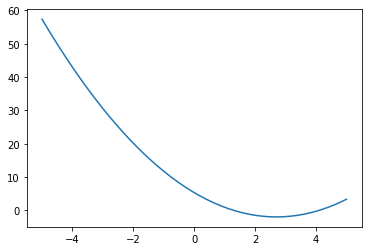

In [13]:
x = np.linspace(-5, 5, num=1000)
y = np.zeros(1000)
for i in range(0,1000):
  y[i] = f(x[i])
plt.plot(x,y)

## Arnoldi iteration
The Arnoldi iteration is used in the GMRES iteration and we implement it here in much the same way as algorithm 7.3 in the lecture notes. To avoid division by almost zero numbers we check that when the norm of $v$ in the algorithm is almost zero we just add the zero vector to $Q$ and then return. 

In [0]:
def arnoldi_iteration(A, b, k):
    if type(A) != np.ndarray or A.ndim != 2:
        raise Exception("A must be a numpy array with ndim=2")
    if type(b) != np.ndarray or b.ndim != 1:
        raise Exception("b must be a numpy array with ndim=1")
    if A.shape[0] != b.size:
        raise Exception("Dimensions of A and b are not compatible")
    
    n = A.shape[0]
    H = np.zeros((k + 1, k))
    Q = np.zeros((n, k + 1))
    Q[:, 0] = b / np.linalg.norm(b)
    
    for j in range(k):
        v = A.dot(Q[:, j])
        for i in range(j + 1):
            H[i, j] = np.dot(Q[:, i].conj(), v)
            v = v - H[i, j] * Q[:, i]

        H[j + 1, j] = np.linalg.norm(v)
        if H[j + 1, j] < 1e-12:
            return Q,H
        Q[:, j + 1] = v / H[j + 1, j]
    return Q, H

## GMRES method
With the Arnoldi iteration implemented and using numpy's least square method the GMRES can be implemented just as in algorithm 7.2 in the lecture notes.

In [0]:
def gmres(A, b, tol=1e-6):
    if type(A) != np.ndarray or A.ndim != 2:
        raise Exception("A must be a numpy array with ndim=2")
    if type(b) != np.ndarray or b.ndim != 1:
        raise Exception("b must be a numpy array with ndim=1")
    if A.shape[0] != b.size:
        raise Exception("Dimensions of A and b are not compatible")
    
    n = A.shape[0]
    Q = np.zeros((n, 1))
    b_norm = np.linalg.norm(b)
    Q[:, 0] = b[:]/b_norm
    y = None
    r = tol * b_norm
    k = 0

    while np.linalg.norm(r) >= tol*b_norm:
        Q, H = arnoldi_iteration(A, b, k)
        v = np.zeros(k+1)
        v[0] = b_norm
        y = np.linalg.lstsq(H, v, rcond=None)[0]
        r = H.dot(y)
        r[:] = v - r[:]
        k += 1
    
    x = Q[:, 0:k-1].dot(y)
    return x, k

### Testing GMRES
We check the GMRES in the same way as we test the Jacobi iteration, except that we do not test the convergence as was tested there and we do not create an initial guess, since the GMRES does not take one.


In [16]:
class TestGMRES(unittest.TestCase):
    def test_gmres(self):
        decimal = 5
        i = 0
        while i<20:
            dim = np.random.randint(2, 10)
            A = 5*np.random.rand(dim,dim)
            if np.allclose(np.linalg.det(A), 0, atol=1e-8):
                continue

            i += 1
            x = 5*np.random.rand(dim)
            b = A.dot(x)
            y = np.zeros(dim)
            y[:] = gmres(A, b)[0]

            np.testing.assert_almost_equal(np.linalg.norm(x - y), 0, decimal=3)
            np.testing.assert_almost_equal(np.linalg.norm(A.dot(y) - b), 0, decimal=decimal)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.369s

OK


# **Results**

## Iterations for linear systems
All of the tests succeeded.

## Newton's method

For the constructed function of several variables the iteration converges within the set tolerace $10^{-3}$

### Random polynomials for one-variable Newton
For the random polynomials in one variable, the method converged most of the times within the set tolerance $10^{-4}$ for the residual $|f(x)|$, and rarely after more than 10 iterations. The difference between the real root and the calculated also converged well in almost every case to a value below $10^{-4}$

# **Discussion**

### Newton's method
For the constructed function of several variables we see that the first two inital values are close to the same root and both converge to the same root. In this case the second inital guess was closer, but not extremely much. Yet with that guess the method converged after 6 iterations while the first one took 27 iterations. Which suggests how important a good initial guess can be.

Comparing to the third initial guess, $x_0^{(3)} = (1, 1, 1, 1, 1)$, this was even further away from any root and eventually converged to a different root than the first two runs. Even though the guess was further away from its root, the method converged after only 6 iterations. This shows that it is not a direct relation between how good the initial guess is and the rate of convergence. It converges faster around some roots than others.

When Newtons method does not converge in the test with the random polynomials, it was almost always between two roots. That is typically the area in which we expect that the method can get stuck oscillating since the derivate changes sign there.